# Intro to PyTorch for classification tasks

We'll use Pytorch together with supporting libraries `tensorlayers` and `skorch` to train a regressor that will map synthetic accoustic seismic waveforms and their corresponding velocity profiles. The dataset was put together by Lukas Mosser and is hosted on github here: [https://github.com/LukasMosser/SNIST](https://github.com/LukasMosser/SNIST)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
urls = [
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/train/train_amplitudes.npy',
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/train/train_velocities.npy',
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_amplitudes.npy',
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_velocities.npy',
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_amplitudes_noise_1.npy',
        'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_amplitudes_noise_2.npy'
    ]

Numpy allows you to point at URL data sources. It'll take care of downloading them and keeping reference of where they are with respect to a root folder specified by the user.

In [4]:
ds = np.DataSource('../data/')

train_amplitudes = np.load(ds.open(urls[0], mode='rb'))
train_velocities = np.load(ds.open(urls[1], mode='rb'))

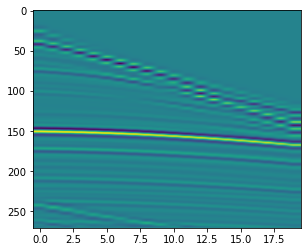

In [5]:
plt.imshow(train_amplitudes[0], aspect=0.06)

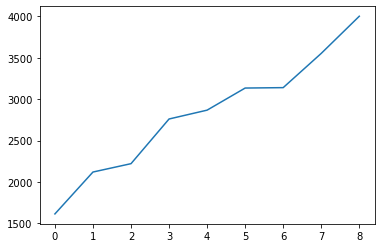

In [6]:
plt.plot(train_velocities[0])

Let's define some dataset parameters. Note that these come from the [SNIST](https://github.com/LukasMosser/SNIST) properties.

In [8]:
N_train = 600    # Number of total training examples
N_val = 150      # Number of samples used for validation
N_samples = 271  # Number of samples in time
N_recorders = 20 # Number of recording stations
N_target = 9     # Number of layers in the target velocity model
N_z = 360        # Number of grid blocks in z-dimension (only used for visualisation)

Now some neural network parameters:

In [10]:
lr = 1e-2                  # Learning rate
batch_size = N_train-N_val # Batchsize used in training - do full batch evaluation because of small data
N_epochs = 200             # Number of epochs to train for

In [11]:
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
# Number of neurons in hidden layer
n_hidden = 50

# Setup a sequential network
model = nn.Sequential(
            nn.Linear(N_recorders*N_samples, n_hidden),
            nn.Sigmoid(),
            nn.Linear(n_hidden, N_target),
        )

model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=5420, out_features=50, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=50, out_features=9, bias=True)
)


We need to make sure the inputs are standarized:

In [13]:
train_mean, train_std = train_amplitudes.mean(), train_amplitudes.std()
train_vel_max = train_velocities.max()

In [14]:
X = train_amplitudes - train_mean
X /= train_std

y = train_velocities / train_vel_max

X_train = X[:-N_val]
y_train = y[:-N_val]


X_test = X[N_train-N_val:]
y_test = y[N_train-N_val:]

Let's confirm that the shapes of these matrices are OK:

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((450, 271, 20), (450, 9), (150, 271, 20), (150, 9))

We want to make the training data to be 1D to be allowed through this fully connected neural network.

In [16]:
X_train = X_train.reshape((N_train-N_val, N_samples*N_recorders))
X_test = X_test.reshape((N_val, N_samples*N_recorders))

Now we can implement 

In [17]:
import torch.utils.data as utils

X_train_ = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_ = torch.tensor(y_train, dtype=torch.float).to(device)

traindata = utils.TensorDataset(X_train_, y_train_)
trainloader = utils.DataLoader(traindata)

In [18]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [19]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"# {epoch+1}  Loss {epoch_loss}")
print('Finished Training')

# 1  Loss 45.25542106223293
# 2  Loss 8.516240772558376
# 3  Loss 5.948286695114803
# 4  Loss 5.48722755163908
# 5  Loss 5.229438937094528
# 6  Loss 5.035574570298195
# 7  Loss 4.879166139173321
# 8  Loss 4.748161585186608
# 9  Loss 4.6355042066425085
# 10  Loss 4.5366936443024315
Finished Training


We can make predictions with the trained model:

In [21]:
X_test_ = torch.tensor(X_test, dtype=torch.float).to(device)
y_test_ = torch.tensor(y_test, dtype=torch.float).to(device)

valdata = utils.TensorDataset(X_test_, y_test_)
valloader = utils.DataLoader(valdata)

In [22]:
y_pred = np.array([model(xi).cpu().detach().numpy() for xi, yi in valloader])
y_pred = np.squeeze(y_pred)

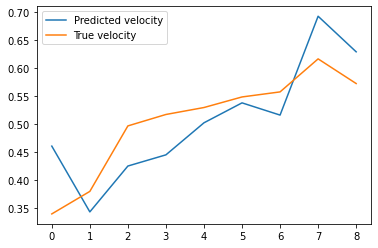

In [23]:
plt.plot(y_pred[0], label='Predicted velocity')
plt.plot(y_test[0], label='True velocity')
plt.legend()

You can save the model like this:

In [24]:
torch.save(model.state_dict(), 'model.ckpt')

### Exercise

- Create a training function to perform the whole training loop. For now, it should receive as parameters `X_train` and `y_train` and return a trained model
- Put as parameter the number of neurons that are part of the single hidden layer and see how the training performance (loss) varies
- Add more hidden layers and train models with different network configurations

In [ ]:
# Your code here.



In [30]:
def pytorch_train(X_train, y_train, n_hidden=[50, 10]):
    """
    Train a fully connected network
    """
    

    # Setup a sequential network
    model = nn.Sequential(
                nn.Linear(N_recorders*N_samples, n_hidden[0]),
                nn.Sigmoid(),
                nn.Linear(n_hidden[0], n_hidden[1]),
                nn.Sigmoid(),
                nn.Linear(n_hidden[1], N_target),
            )

    model.to(device)
    
    X_train_ = torch.tensor(X_train, dtype=torch.float).to(device)
    y_train_ = torch.tensor(y_train, dtype=torch.float).to(device)

    traindata = utils.TensorDataset(X_train_, y_train_)
    trainloader = utils.DataLoader(traindata)
    
    optimizer = optim.SGD(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    epochs = 10

    for epoch in range(epochs):
        epoch_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"# {epoch+1}  Loss {epoch_loss}")
    print('Finished Training')
    
    return model

In [31]:
model = pytorch_train(X_train, y_train)

# 1  Loss 214.97292317450047
# 2  Loss 100.57427180558443
# 3  Loss 48.50081576034427
# 4  Loss 24.487361057195812
# 5  Loss 13.673122039530426
# 6  Loss 8.937431528582238
# 7  Loss 6.907097639050335
# 8  Loss 6.046169661160093
# 9  Loss 5.680416120449081
# 10  Loss 5.52166322118137
Finished Training


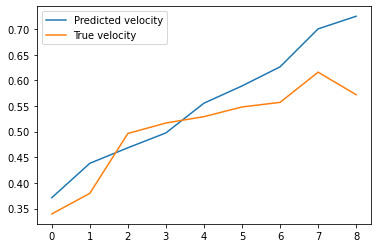

In [32]:
y_pred = np.array([model(xi).cpu().detach().numpy() for xi, yi in valloader])
y_pred = np.squeeze(y_pred)

plt.plot(y_pred[0], label='Predicted velocity')
plt.plot(y_test[0], label='True velocity')
plt.legend()

A couple of extra libraries can help the process of making neural networks with Pytorch:
- `Torchlayers`: Figures out dimensionality of input and output of each layer
- `skorch`: Provides a `scikit-learn` compatible object from a `Pytorch` network to incorporate in scikit-learn workflows

In [26]:
import torchlayers as tl
from skorch import NeuralNetRegressor

A model can now be created like this:

In [27]:
# Define the architecture of the network
net_arch = torch.nn.Sequential(
    tl.Linear(50),  # specify ONLY out_channels
    tl.Sigmoid(),  # activation from first hidden layer
    tl.Linear(10),  # specify ONLY out_channels
    tl.Sigmoid(), # activation from second hidden layer
    tl.Linear(N_target),  # Output for 10 classes
)

# Build the network
net = tl.build(net_arch, torch.randn(1, *X_train[0].shape)) # torchlayers needs an input example to figure out the internal dimensions of the network

Now we can create the scikit-learn compatible object:

In [28]:
model = NeuralNetRegressor(
    net,
    max_epochs=10,
    lr=0.01,
)

model.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4054        0.3839  0.0355
      2        0.3876        0.3670  0.0339
      3        0.3708        0.3510  0.0340
      4        0.3548        0.3359  0.0341
      5        0.3396        0.3214  0.0330
      6        0.3251        0.3077  0.0346
      7        0.3114        0.2946  0.0317
      8        0.2983        0.2822  0.0326
      9        0.2858        0.2703  0.0326
     10        0.2739        0.2590  0.0308


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=5420, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=9, bias=True)
  ),
)

In [29]:
y_proba = model.predict(X_test)
y_proba[0]

array([ 0.37250727,  0.0817999 ,  0.1639305 ,  0.18484697, -0.02029371,
       -0.06167622,  0.26306498,  0.25315076, -0.17384966], dtype=float32)

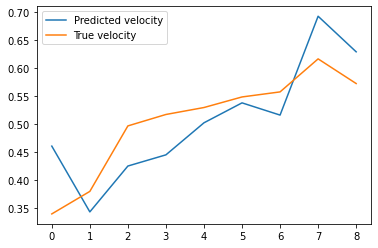

In [30]:
plt.plot(y_pred[0], label='Predicted velocity')
plt.plot(y_test[0], label='True velocity')
plt.legend()

# Convolutional Neural Networks
What'as a Convolutional Neural Network?
 - Keep these cheatsheets at hand: https://github.com/afshinea/stanford-cs-230-deep-learning
 
![alt text](../images/convolution-layer-a.png)

## What's max-pooling?
![alt text](../images/max-pooling-a.png)

In [63]:
X = train_amplitudes - train_mean
X /= train_std

y = train_velocities / train_vel_max

X_train = X[:-N_val]
y_train = y[:-N_val]


X_test = X[N_train-N_val:]
y_test = y[N_train-N_val:]

In [71]:
# torch.nn and torchlayers can be mixed easily
net_arch = torch.nn.Sequential(
    tl.Conv(32),  # specify ONLY out_channels
    nn.ReLU(),  # use torch.nn wherever you wish
    tl.GlobalMaxPool(),  # Known from Keras
    tl.Linear(5), # Add a fully connected hidden layer
    tl.ReLU(), # Activate the hidden layer
    tl.Linear(9),  # Output for target linear output
)

net = tl.build(net_arch, torch.randn(1, *X_train[0].shape))

In [72]:
model = NeuralNetRegressor(
    net,
    max_epochs=10,
    lr=0.01,
)

model.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5284        0.5029  0.0508
      2        0.5102        0.4920  0.0481
      3        0.4996        0.4841  0.0368
      4        0.4914        0.4771  0.0404
      5        0.4843        0.4705  0.0325
      6        0.4777        0.4641  0.0303
      7        0.4713        0.4579  0.0337
      8        0.4651        0.4518  0.0271
      9        0.4590        0.4458  0.0373
     10        0.4529        0.4400  0.0294


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Sequential(
    (0): Conv1d(271, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): GlobalMaxPool()
    (3): Linear(in_features=32, out_features=5, bias=True)
    (4): ReLU()
    (5): Linear(in_features=5, out_features=9, bias=True)
  ),
)

In [73]:
y_proba = model.predict(X_test)
y_proba[0]

array([-0.12365484,  0.3677009 , -0.27451143,  0.078548  ,  0.0347712 ,
       -0.18177536,  0.02863209, -0.234974  , -0.12830147], dtype=float32)

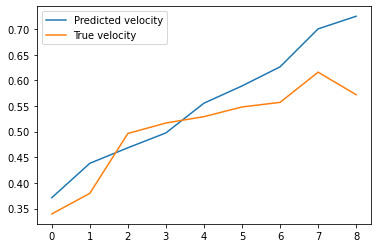

In [74]:
plt.plot(y_pred[0], label='Predicted velocity')
plt.plot(y_test[0], label='True velocity')
plt.legend()

## Model persistence

The easiest way to save a model is to `pickle` the trained model object.

In [78]:
import pickle

# saving
with open('torch_regressor.pkl', 'wb') as f:
    pickle.dump(model, f)

# loading
with open('torch_regressor.pkl', 'rb') as f:
    model = pickle.load(f)

In [80]:
model.predict(X_test)

array([[-0.12365484,  0.3677009 , -0.27451143, ...,  0.02863209,
        -0.234974  , -0.12830147],
       [-0.12365484,  0.3677009 , -0.27451143, ...,  0.02863209,
        -0.234974  , -0.12830147],
       [-0.12365484,  0.3677009 , -0.27451143, ...,  0.02863209,
        -0.234974  , -0.12830147],
       ...,
       [-0.12365484,  0.3677009 , -0.27451143, ...,  0.02863209,
        -0.234974  , -0.12830147],
       [-0.12365484,  0.3677009 , -0.27451143, ...,  0.02863209,
        -0.234974  , -0.12830147],
       [-0.12365484,  0.3677009 , -0.27451143, ...,  0.02863209,
        -0.234974  , -0.12830147]], dtype=float32)